The purpose of this Jupyter notebook is to analyze Fiber Photometry Data recorded by a TDT system

The notebook is  adapted from  Thoam Akam & Lauren Burgeno by referring to Simpson et al. 2023

The preprocessing consists of the following steps:

  1. Lowpass filtering to reduce noise (10 Hz filter).

  2. Correction for photobleaching, over time. A double exponential fit is utilized for this purpose.
  
  3. Movement correction by subtracting a linear fit of the movement control channel.

  4.  z-scoring the data
  


Import all necessary packages

In [22]:
import pandas as pd
import numpy as np
import matplotlib
import tdt
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from scipy.signal import medfilt, butter,filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

Jupyter has a bug that requires import of matplotl
matplotlib inline magic to properly apply rcParams
Set some other parameter

In [23]:
matplotlib.rcParams["font.size"] 
REF_EPOC = "Note"  # event store 
ISOS = "_405A"  # 405nm channel.
GCaMP = "_465A"  # 465nm channel.
Pinky = "_560B"  # 560nm channel.

First define the path to your data

In [24]:
BLOCKPATH = "/Volumes/Test/TDT/FP/FibPho_PinkyCaMP/FibPho_Airpuff_17102024_final_Airpuff/0934-241017-143128" # insert your  file path here

Read the data

In [25]:
data = tdt.read_block(BLOCKPATH)

Found Synapse note file: /Volumes/Test/TDT/FP/FibPho_PinkyCaMP/FibPho_Airpuff_17102024_final_Airpuff/0934-241017-143128/Notes.txt
read from t=0s to t=572.59s


Make time vectors and plot the unprocessed data 

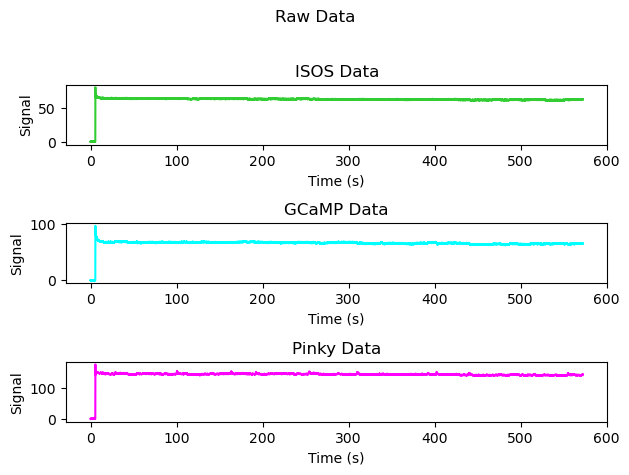

In [26]:
# Make time vector for plotting

# Make time vector for plotting
time_405A = (
    np.linspace(
        0, 
        len(getattr(data.streams, ISOS).data) / getattr(data.streams, ISOS).fs, 
        len(getattr(data.streams, ISOS).data)
    )
)

# Sampling rates
sampling_rate_405 = getattr(data.streams, ISOS).fs
sampling_rate_465 = getattr(data.streams, GCaMP).fs
sampling_rate_560 = getattr(data.streams, Pinky).fs

# Make time vectors for plotting
time_465A = (
    np.linspace(
        0,
        len(getattr(data.streams, GCaMP).data) / getattr(data.streams, GCaMP).fs,
        len(getattr(data.streams, GCaMP).data)
    )
)

time_560B = (
    np.linspace(
        0,
        len(getattr(data.streams, Pinky).data) / getattr(data.streams, Pinky).fs,
        len(getattr(data.streams, Pinky).data)
    )
)
# Plot  raw traces
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(3, 1)
fig.suptitle("Raw Data")

# Plotting on the first subplot
axs[0].plot(time_405A, getattr(data.streams, ISOS).data, color="limegreen")
axs[0].set_title('ISOS Data')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Signal')

# Plotting on the second subplot
axs[1].plot(time_465A, getattr(data.streams, GCaMP).data, color="cyan")
axs[1].set_title('GCaMP Data')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Signal')

# Plotting on the third subplot
axs[2].plot(time_560B, getattr(data.streams, Pinky).data, color="magenta")
axs[2].set_title('Pinky Data')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Signal')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust `rect` to fit suptitle

plt.show()

Typically you get an artifact from the LEDs in the beginning of the recording.Here we remove the first seconds to get rid of it

In [27]:
# Trim data to start of LED onset via values /PC0 and video recording onset
length_of_array = len(time_405A)
offset = length_of_array / data.streams._405A.fs
onset_LED = 10 # choose where to start the trial
offset_LED = offset
#offset_LED = 305 #alternatialy also choose the end of the recording
isobestic_raw = []
GCaMP_raw = []
Pinky_raw = []
duration = offset_LED - onset_LED
delay = 0

# trim isobestic data
for t, x in zip(time_405A, getattr(data.streams, ISOS).data):
    # Check if the time falls within the LEDon period
    if onset_LED + delay <= t <= offset_LED:
        isobestic_raw.append(x)

for t, x in zip(time_465A, getattr(data.streams, GCaMP).data):
    # Check if the time falls within the LEDon period
    if onset_LED + delay <= t <= offset_LED:
        GCaMP_raw.append(x)

for t, x in zip(time_560B, getattr(data.streams, Pinky).data):
    # Check if the time falls within the LEDon period
    if onset_LED + delay <= t <= offset_LED:
        Pinky_raw.append(x)

time_LED_465A = np.linspace(0, len(GCaMP_raw), len(GCaMP_raw)) / data.streams._465A.fs
time_LED_405A = (
    np.linspace(0, len(isobestic_raw), len(isobestic_raw)) / data.streams._405A.fs
)
time_LED_560B = np.linspace(0, len(Pinky_raw), len(Pinky_raw)) / data.streams._560B.fs

time_seconds = time_LED_405A

Now implement a 10 Hz cut off filter

In [28]:
# Define the filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Filter requirements 465A
order = 2
fs = data.streams._465A.fs  # sample rate, Hz
cutoff = 10  # desired cutoff frequency of the filter, Hz

# Filter requirements 405A
order = 2
fs = data.streams._405A.fs  # sample rate, Hz
cutoff = 10  # desired cutoff frequency of the filter, Hz

# Filter requirements 560B
order = 2
fs = data.streams._560B.fs  # sample rate, Hz
cutoff = 10  # desired cutoff frequency of the filter, Hz

# Apply filter to all of your data
filtered_data_405A = butter_lowpass_filter(isobestic_raw, cutoff, fs, order)
filtered_data_465A = butter_lowpass_filter(GCaMP_raw, cutoff, fs, order)
filtered_data_560B = butter_lowpass_filter(Pinky_raw, cutoff, fs, order)

Find events, such as an aversive Airpuff, open arm entry (...) that have been marked during your recording to later plot and align these to the FibPho data

In [29]:
# find the events, such as open arm to closed arm, airpuff (...)that are stored as  a Note in the TDT data tank or insert the timestamps for these events manually in the varibale (onset_behavior)

events = data.epocs.Note.notes
onset = data.epocs.Note.onset
offset = data.epocs.Note.offset
EVENT = "Airpuff"
##EVENT = "closed arm to open"
#EVENT = "open arm to closed arm"
indices = np.where(events == EVENT)[0]
event_values_onset = onset[indices]
print(event_values_onset)

# !!!! Subtract onset from each element in airpuff_values!!!! you trimmed the data before
adjusted_event_values = event_values_onset - onset_LED
onset_behavior = adjusted_event_values
print(onset_behavior)


[100.4191744  163.40451328 192.12599296 253.7373696  309.97889024
 402.05484032 439.95250688 555.07943424]
[ 90.4191744  153.40451328 182.12599296 243.7373696  299.97889024
 392.05484032 429.95250688 545.07943424]


Plot filtered traces

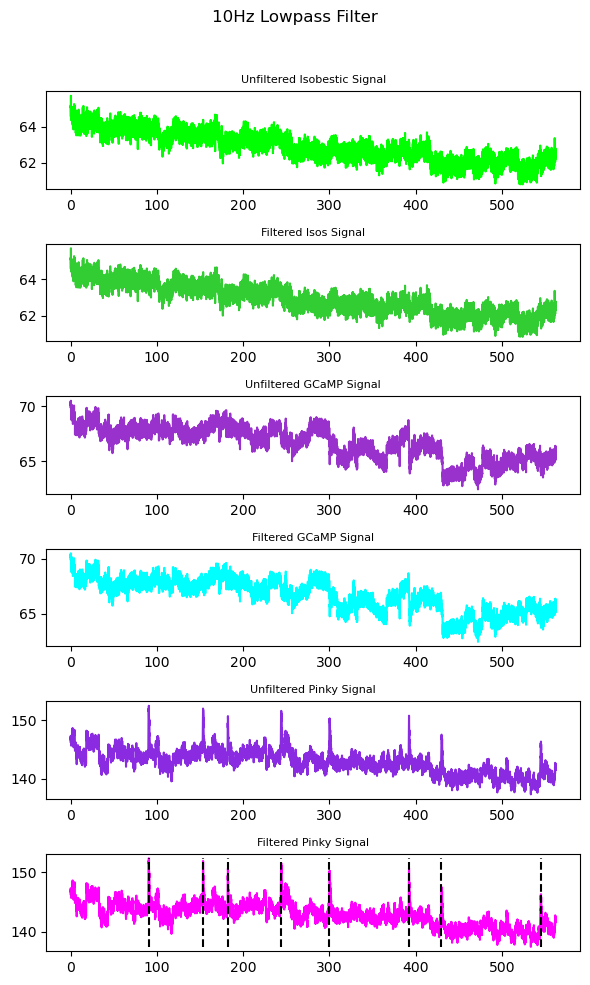

In [30]:
# plotting

# Adjust the figure size if necessary
fig, axs = plt.subplots(6, 1, figsize=(6, 10))
fig.suptitle("10Hz Lowpass Filter", fontsize=12)

# Plot data in each subplot
axs[0].plot(time_LED_405A, isobestic_raw, color="lime")
axs[0].set_title("Unfiltered Isobestic Signal", fontsize=8)

axs[1].plot(time_LED_405A, filtered_data_405A, color="limegreen")
axs[1].set_title("Filtered Isos Signal", fontsize=8)

axs[2].plot(time_LED_465A, GCaMP_raw, color="darkorchid")
axs[2].set_title("Unfiltered GCaMP Signal", fontsize=8)

axs[3].plot(time_LED_560B, filtered_data_465A, color="cyan")
axs[3].set_title("Filtered GCaMP Signal", fontsize=8)

axs[4].plot(time_LED_560B, Pinky_raw, color="blueviolet")
axs[4].set_title("Unfiltered Pinky Signal", fontsize=8)

axs[5].plot(time_LED_560B, filtered_data_560B, color="magenta")
axs[5].set_title("Filtered Pinky Signal", fontsize=8)

# Plotting behavioral events as vertical lines
axs[5].vlines(
    onset_behavior,  # X-coordinates for the lines
    # Starting point of the vertical line (y-min)
    ymin=min(filtered_data_560B),
    ymax=max(filtered_data_560B),  # Ending point of the vertical line (y-max)
    color="black",  # Line color
    linestyle="--",  # Line style (dashed)
    label="Behavioral Event",  # Legend label
)

# Set the font size for all axis tick labels
for ax in axs:
    ax.tick_params(axis="both", labelsize=10)  # Adjust the font size as needed

# Adjust layout to prevent overlap and ensure everything fits
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leaves space for the suptitle

# Display the plot
plt.show()


Correction for photobleaching via a double exponential fit

In [31]:
def double_exponential(t, const, amp_fast, amp_slow, tau_slow, tau_multiplier):
    """Compute a double exponential function with constant offset.
    Parameters:
    t       : Time vector in seconds.
    const   : Amplitude of the constant offset.
    amp_fast: Amplitude of the fast component.
    amp_slow: Amplitude of the slow component.
    tau_slow: Time constant of slow component in seconds.
    tau_multiplier: Time constant of fast component relative to slow.
    """
    tau_fast = tau_slow * tau_multiplier
    return const + amp_slow * np.exp(-t / tau_slow) + amp_fast * np.exp(-t / tau_fast)

# Fit curve to GCaMP.
max_sig = np.max(filtered_data_465A)
inital_params = [max_sig / 2, max_sig / 4, max_sig / 4, 3600, 0.1]
bounds = ([0, 0, 0, 600, 0], [max_sig, max_sig, max_sig, 36000, 1])
GCaMP_parms, parm_cov = curve_fit(
    double_exponential,
    time_LED_465A,
    filtered_data_465A,
    p0=inital_params,
    bounds=bounds,
    maxfev=1000,
)
GCaMP_expfit = double_exponential(time_LED_465A, *GCaMP_parms)

# fit cure to isobestic
max_sig = np.max(filtered_data_405A)
inital_params = [max_sig / 2, max_sig / 4, max_sig / 4, 3600, 0.1]
bounds = ([0, 0, 0, 600, 0], [max_sig, max_sig, max_sig, 36000, 1])
isos_parms, parm_cov = curve_fit(
    double_exponential,
    time_LED_405A,
    filtered_data_405A,
    p0=inital_params,
    bounds=bounds,
    maxfev=1000,
)
isos_expfit = double_exponential(time_LED_405A, *isos_parms)

# fit curve to Pinky
max_sig = np.max(filtered_data_560B)
inital_params = [max_sig / 2, max_sig / 4, max_sig / 4, 3600, 0.1]
bounds = ([0, 0, 0, 600, 0], [max_sig, max_sig, max_sig, 36000, 1])
Pinky_parms, parm_cov = curve_fit(
    double_exponential,
    time_LED_560B,
    filtered_data_560B,
    p0=inital_params,
    bounds=bounds,
    maxfev=1000,
)
Pinky_expfit = double_exponential(time_LED_560B, *Pinky_parms)

# Fit the double exponential curve to the data 405A by substraction of
# the fit this is used if the bleaching is dominated by autofluorescence, then it will affect the baseline
# but not the amplitude of pyhsiological variation recommendation by Simpson et al. 2023
photobleaching_corr_465 = filtered_data_465A - GCaMP_expfit
photobleaching_corr_405 = filtered_data_405A - isos_expfit
photobleaching_corr_560 = filtered_data_560B - Pinky_expfit


# Alternatively fit the double exponential curve to the data  by division. Note: the signal is converted to deltaF/F by the division
# photobleaching_corr_465 = filtered_data_465A - GCaMP_expfit / GCaMP_expfit
# photobleaching_corr_405 = filtered_data_405A - isos_expfit / isos_expfit
# photobleaching_corr_560 = filtered_data_560B - Pinky_expfit / Pinky_expfit  #

Plot the original data and the fitted curve

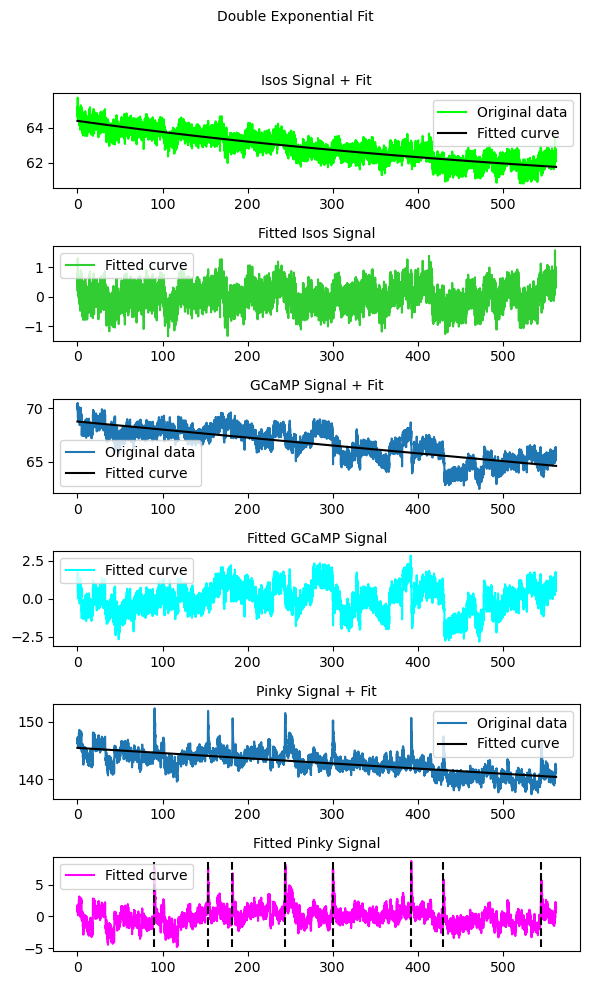

In [32]:
fig, axs = plt.subplots(6, 1, figsize=(6, 10))  # Adjust figure size if needed

# Set the main title font size
fig.suptitle("Double Exponential Fit", fontsize=10)

# Plot data in each subplot and set font sizes
axs[0].plot(time_LED_405A, filtered_data_405A, label="Original data", color="lime")
axs[0].plot(time_LED_405A, isos_expfit, color="black", label="Fitted curve")
axs[0].set_title("Isos Signal + Fit", fontsize=10)
axs[0].legend(fontsize=10)  # Set legend font size

axs[1].plot(
    time_LED_465A, photobleaching_corr_405, color="limegreen", label="Fitted curve"
)
axs[1].set_title("Fitted Isos Signal", fontsize=10)
axs[1].legend(fontsize=10)  # Set legend font size

axs[2].plot(time_LED_465A, filtered_data_465A, label="Original data")
axs[2].plot(time_LED_465A, GCaMP_expfit, color="black", label="Fitted curve")
axs[2].set_title("GCaMP Signal + Fit", fontsize=10)
axs[2].legend(fontsize=10)  # Set legend font size

axs[3].plot(time_LED_465A, photobleaching_corr_465, color="cyan", label="Fitted curve")
axs[3].set_title("Fitted GCaMP Signal", fontsize=10)
axs[3].legend(fontsize=10)  # Set legend font size

axs[4].plot(time_LED_560B, filtered_data_560B, label="Original data")
axs[4].plot(time_LED_560B, Pinky_expfit, color="black", label="Fitted curve")
axs[4].set_title("Pinky Signal + Fit", fontsize=10)
axs[4].legend(fontsize=10)  # Set legend font size

axs[5].plot(
    time_LED_560B, photobleaching_corr_560, color="magenta", label="Fitted curve"
)
axs[5].set_title("Fitted Pinky Signal", fontsize=10)
axs[5].legend(fontsize=10)  # Set legend font size

# Plotting behavioral events as vertical lines
axs[5].vlines(
    onset_behavior,  # X-coordinates for the lines
    ymin=min(photobleaching_corr_560),  # Starting point of the vertical line (y-min)
    ymax=max(photobleaching_corr_560),  # Ending point of the vertical line (y-max)
    color="black",  # Line color
    linestyle="--",  # Line style (dashed)
    label="Behavioral Event",  # Legend label
)

# Set the font size for all axis tick labels
for ax in axs:
    ax.tick_params(axis="both", labelsize=10)  # Set tick label font size

# Adjust layout to prevent overlap
plt.tight_layout(
    rect=[0, 0, 1, 0.96]
)  # Adjust the rect parameter as needed to fit the suptitle

plt.show()

Substitute the data in data stream with the photoblaahcing corrected

In [ ]:
# Ersetzen der Daten in data Struc mit neuen gefitteten
data.streams._405A.data = photobleaching_corr_405
data.streams._465A.data = photobleaching_corr_465
data.streams._560B.data = photobleaching_corr_560

Motion correction by finding the best linear fit of the
isobestic signal to the signal and subtracting this estimated motion component from it.
We will use the data that was bleaching corrected using the double exponential fit as this is less likely to remove meaningful
slow variation in the signals.

Slope    : 0.808
R-squared: 0.116


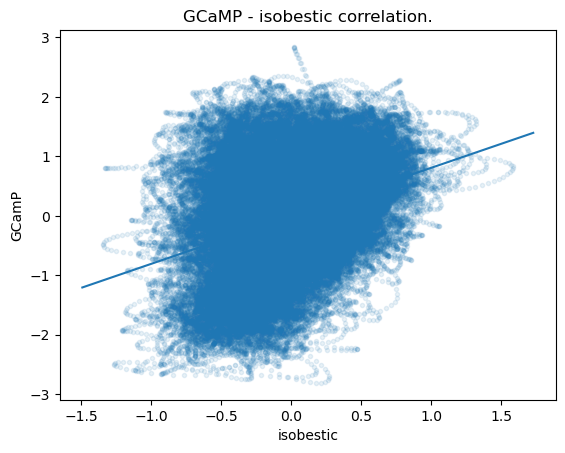

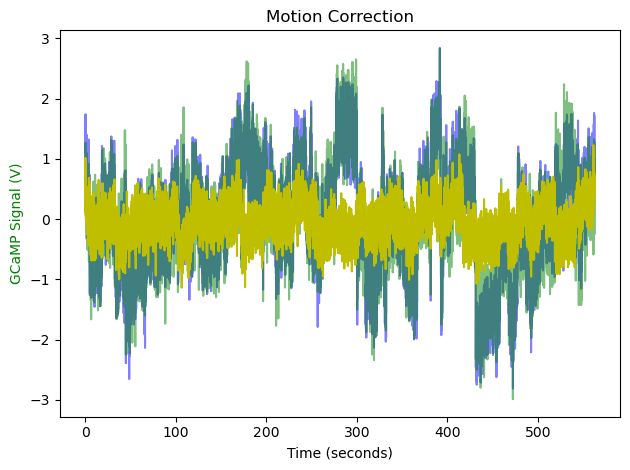

Slope    : 1.089
R-squared: 0.075


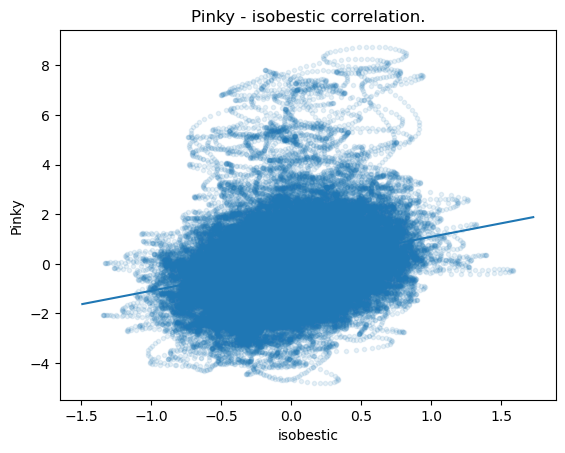

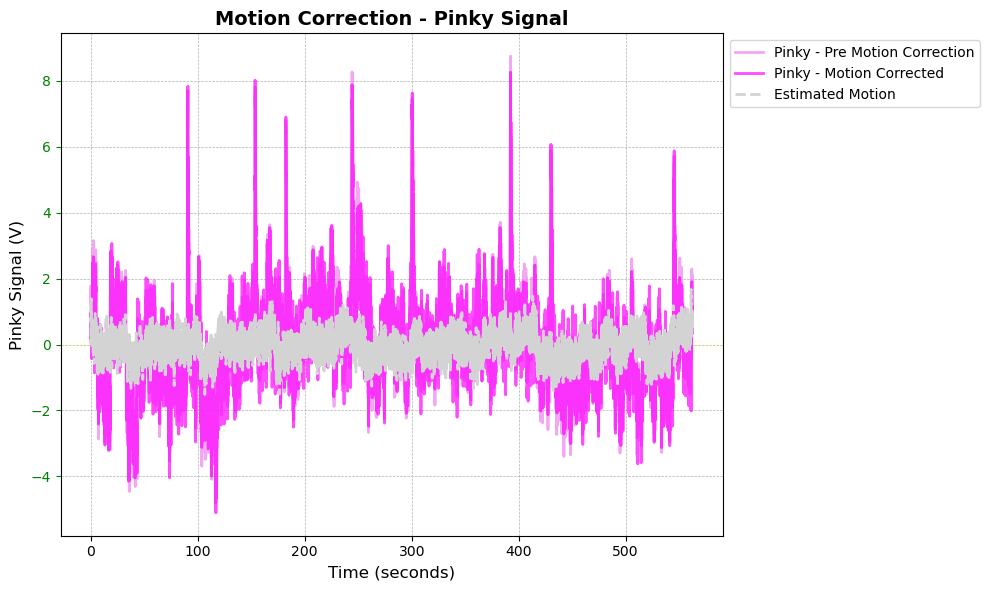

In [33]:
isobestic_detrended = photobleaching_corr_405
GCaMP_detrended = photobleaching_corr_465
Pinky_detrended = photobleaching_corr_560
time_seconds = time_LED_405A

slope, intercept, r_value, p_value, std_err = linregress(
    x=isobestic_detrended, y=GCaMP_detrended
)

plt.scatter(isobestic_detrended[::5], GCaMP_detrended[::5], alpha=0.1, marker=".")
x = np.array(plt.xlim())
plt.plot(x, intercept + slope * x)
plt.xlabel("isobestic")
plt.ylabel("GCamP")
plt.title("GCaMP - isobestic correlation.")

print("Slope    : {:.3f}".format(slope))
print("R-squared: {:.3f}".format(r_value**2))

# We now calculate the estimated motion component of the GCaMP signal and subtract to get the motion corrected 
GCaMP_est_motion = intercept + slope * isobestic_detrended
GCaMP_corrected = GCaMP_detrended - GCaMP_est_motion
fig, ax1 = plt.subplots()
plot1 = ax1.plot(
    time_seconds, GCaMP_detrended, "b", label="GCaMP - pre motion correction", alpha=0.5
)
plot3 = ax1.plot(
    time_seconds, GCaMP_corrected, "g", label="GCaMP - motion corrected", alpha=0.5
)
plot4 = ax1.plot(time_seconds, GCaMP_est_motion - 0.05, "y", label="estimated motion")
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("GCaMP Signal (V)", color="g")
ax1.set_title("Motion Correction")
plt.tight_layout()
plt.show()

slope, intercept, r_value, p_value, std_err = linregress(
    x=isobestic_detrended, y=Pinky_detrended
)

plt.scatter(isobestic_detrended[::5], Pinky_detrended[::5], alpha=0.1, marker=".")
x = np.array(plt.xlim())
plt.plot(x, intercept + slope * x)
plt.xlabel("isobestic")
plt.ylabel("Pinky")
plt.title("Pinky - isobestic correlation.")
print("Slope    : {:.3f}".format(slope))
print("R-squared: {:.3f}".format(r_value**2))

# We now calculate the estimated motion component of the Pinky signal and subtract to get the motion corrected 
Pinky_est_motion = intercept + slope * isobestic_detrended
Pinky_corrected = Pinky_detrended - Pinky_est_motion

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Pinky - pre motion correction (detrended)
plot1 = ax1.plot(
    time_seconds,
    Pinky_detrended,
    color="violet",
    label="Pinky - Pre Motion Correction",
    alpha=0.7,
    linewidth=2,
)

# Plot Pinky - motion corrected
plot3 = ax1.plot(
    time_seconds,
    Pinky_corrected,
    color="magenta",
    label="Pinky - Motion Corrected",
    alpha=0.7,
    linewidth=2,
)

# Plot estimated motion, offset for better visibility
plot4 = ax1.plot(
    time_seconds,
    Pinky_est_motion - 0.05,
    color="lightgray",
    label="Estimated Motion",
    linestyle="--",
    linewidth=2,
)

# Add grid, titles, and labels with enhanced font size
ax1.set_xlabel("Time (seconds)", fontsize=12)
ax1.set_ylabel("Pinky Signal (V)", fontsize=12)
ax1.set_title("Motion Correction - Pinky Signal", fontsize=14, fontweight="bold")

# Improve the appearance of the legend and place it outside the plot
lines = plot1 + plot3 + plot4
labels = [l.get_label() for l in lines]
legend = ax1.legend(
    lines, labels, loc="upper left", bbox_to_anchor=(1, 1), fontsize=10, frameon=True
)

# Add gridlines
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Add shaded region for better visual emphasis on important signal parts (optional)
ax1.axhspan(-0.1, 0.1, color="lightyellow", alpha=0.3, label="Shaded Area")

# Make the y-axis labels a little more distinguishable
ax1.tick_params(axis="y", colors="green", labelsize=10)
ax1.tick_params(axis="x", labelsize=10)

# Adjust layout to fit the legend
plt.tight_layout()

plt.show()

Z-scoring of the data 

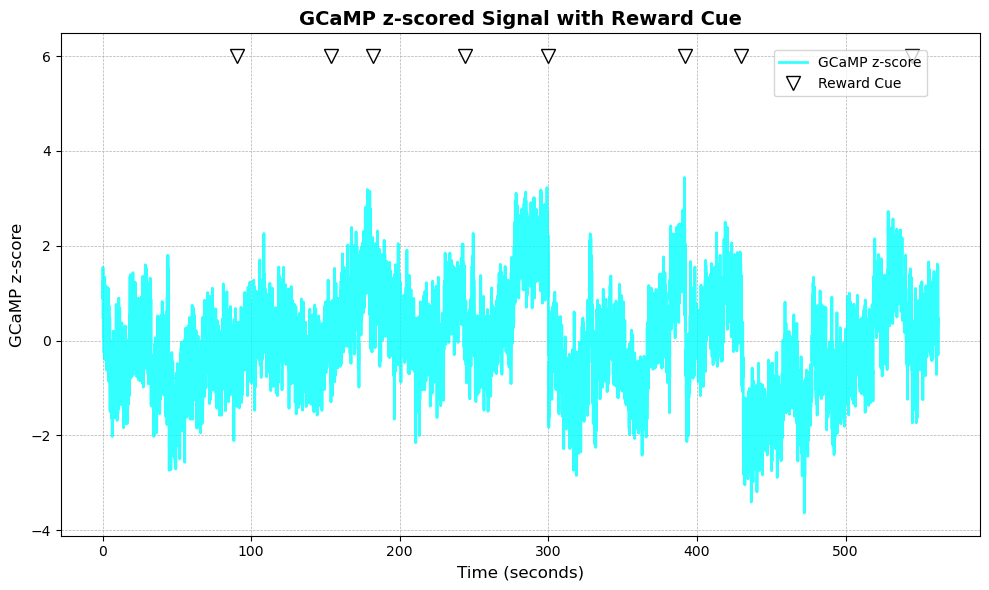

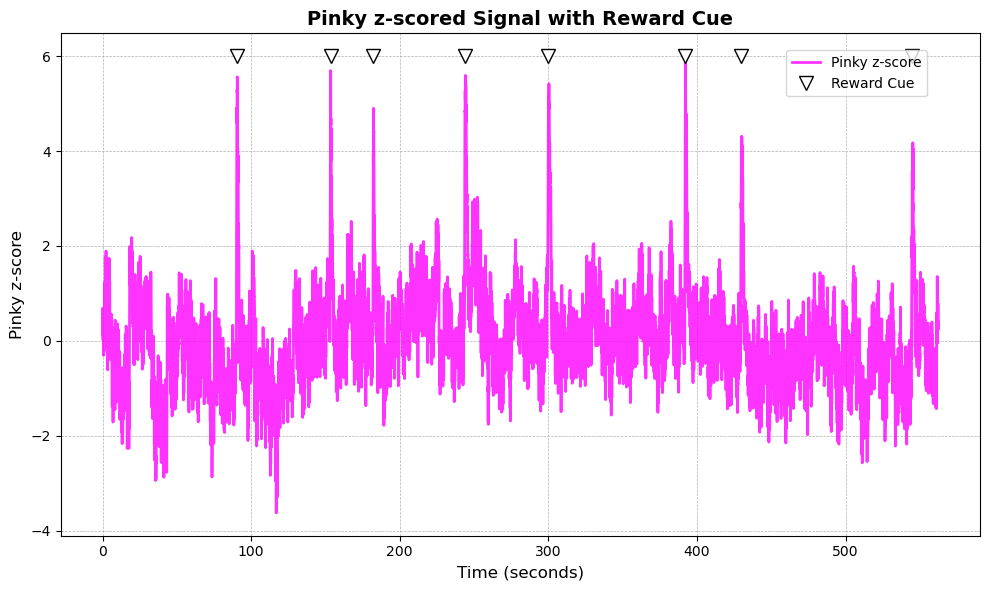

In [34]:
# Z-scoring all data _corrected is the motion corrected signal

# Z-score the GCaMP data

GCaMP_zscored = (GCaMP_corrected - np.mean(GCaMP_corrected)) / np.std(GCaMP_corrected)

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the GCaMP z-scored signal
plot1 = ax1.plot(
    time_seconds,
    GCaMP_zscored,
    color="cyan",
    label="GCaMP z-score",
    linewidth=2,
    alpha=0.8,
)

# Plot reward cue markers
reward_ticks = ax1.plot(
    onset_behavior,
    np.full(np.size(onset_behavior), 6),  # Plot at a constant value of 6
    label="Reward Cue",
    color="k",  # Black marker
    marker="v",  # Downward triangle marker
    linestyle="None",
    mfc="white",  # Marker face color white
    mec="black",  # Marker edge color black
    ms=10,  # Marker size
)

# Set labels and title
ax1.set_xlabel("Time (seconds)", fontsize=12)
ax1.set_ylabel("GCaMP z-score", fontsize=12)
ax1.set_title("GCaMP z-scored Signal with Reward Cue", fontsize=14, fontweight="bold")

# Combine plot lines for the legend
lines = plot1 + reward_ticks
labels = [l.get_label() for l in lines]

# Create legend
legend = ax1.legend(
    lines,
    labels,
    loc="upper right",
    bbox_to_anchor=(0.95, 0.98),
    fontsize=10,
    frameon=True,
)

# Add grid for better visibility of values
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
#ax1.set_xlim(0,300)
# Adjust layout to make room for legend and avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


# Z-score the Pinky data
Pinky_zscored = (Pinky_corrected - np.mean(Pinky_corrected)) / np.std(Pinky_corrected)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the Pinky z-scored signal
plot1 = ax1.plot(
    time_seconds,
    Pinky_zscored,
    color="magenta",
    label="Pinky z-score",
    linewidth=2,
    alpha=0.8,
)

# Plot reward cue markers
reward_ticks = ax1.plot(
    onset_behavior,
    np.full(np.size(onset_behavior), 6),  # Position markers at y=6
    label="Reward Cue",
    color="black",  # Black outline and marker
    marker="v",  # Downward triangle marker
    linestyle="None",
    mfc="white",  # White face color for markers
    mec="black",  # Black edge color for markers
    ms=10,  # Size of the markers
)

# Set x and y axis labels
ax1.set_xlabel("Time (seconds)", fontsize=12)
ax1.set_ylabel("Pinky z-score", fontsize=12)
#ax1.set_xlim(30,300)
# Set title
ax1.set_title("Pinky z-scored Signal with Reward Cue", fontsize=14, fontweight="bold")

# Add legend
lines = plot1 + reward_ticks
labels = [l.get_label() for l in lines]
legend = ax1.legend(
    lines,
    labels,
    loc="upper right",
    bbox_to_anchor=(0.95, 0.98),
    fontsize=10,
    frameon=True,
)

# Add gridlines for better readability
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Adjust the layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

Plot z-scored data  according to the choosen event, e.g. airpuff

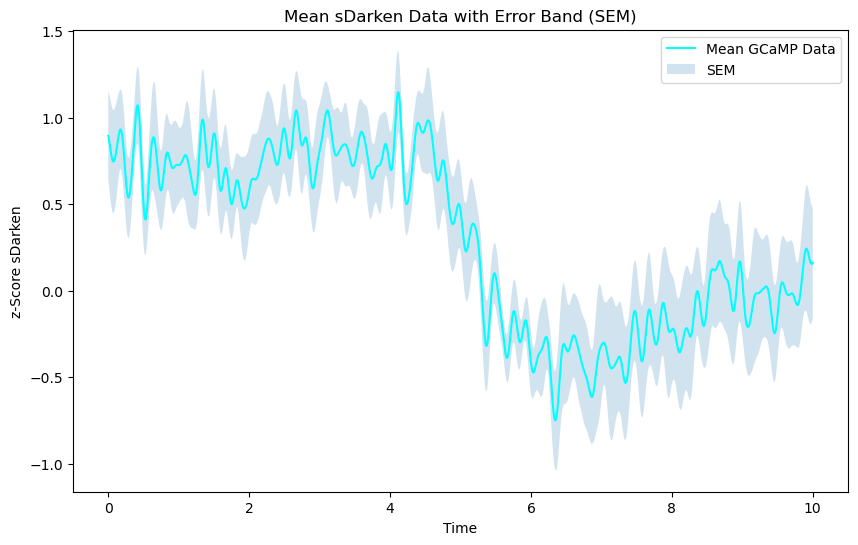

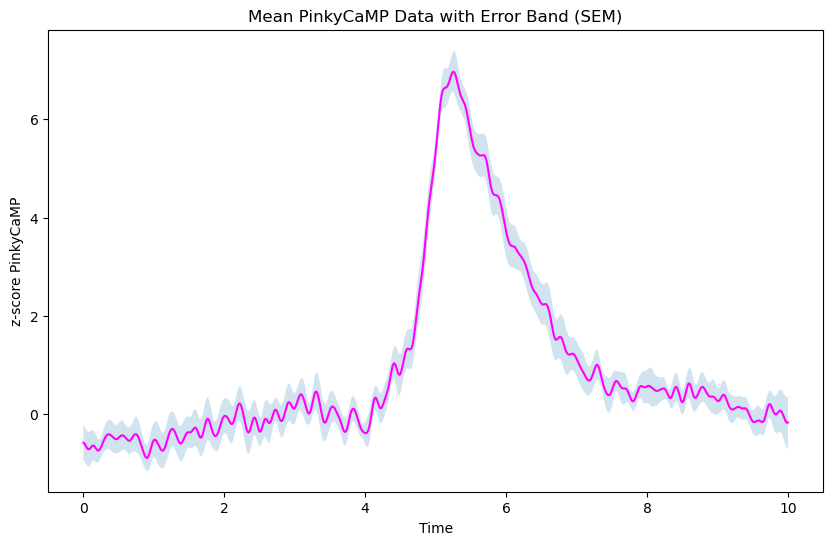

In [35]:
# Sort data in time windws around the EVENT
timing_vector = time_seconds

# Define the window size (5 seconds before and after each onset)
time_window = 5  # in seconds

# Initialize lists to store extracted windows
windows_time = []
windows_gcamp = []
windows_isos = []
windows_pinky = []

# Extract windows around each timepoint of interest
for timepoint_of_interest in onset_behavior:
    # Find the index in the time vector closest to the timepoint of interest
    index = np.abs(timing_vector - timepoint_of_interest).argmin()

    # Calculate the start and end indices for the window
    start_index = max(
        0,
        index
        - int(
            time_window * len(timing_vector) / (timing_vector[-1] - timing_vector[0])
        ),
    )
    end_index = min(
        len(timing_vector) - 1,
        index
        + int(
            time_window * len(timing_vector) / (timing_vector[-1] - timing_vector[0])
        ),
    )

    # Extract the window of time vector and corresponding data
    window_time = timing_vector[start_index : end_index + 1]
    window_gcamp = GCaMP_detrended[start_index : end_index + 1]
    window_pinky = Pinky_detrended[start_index : end_index + 1]
    window_isos = isobestic_detrended[start_index : end_index + 1]

    # Store the extracted window
    windows_time.append(window_time)
    windows_gcamp.append(window_gcamp)
    windows_isos.append(window_isos)
    windows_pinky.append(window_pinky)


 # calculate  mean over all trials for each channel
mean_GCaMP_event = np.mean(windows_gcamp, axis=0)
time_vector = np.linspace(0, time_window + time_window, len(mean_GCaMP_event))
sem_gcamp = np.std(windows_gcamp, axis=0) / np.sqrt(len(windows_gcamp))

# calculate for isos
mean_isos_event = np.mean(windows_isos, axis=0)
# time_vector = np.linspace(0, 1, len(mean_GCamP_event))
sem_isos = np.std(windows_isos, axis=0) / np.sqrt(len(windows_isos))

mean_Pinky_event = np.mean(windows_pinky, axis=0)
time_vector = np.linspace(0, time_window + time_window, len(mean_Pinky_event))
sem_Pinky = np.std(windows_pinky, axis=0) / np.sqrt(len(windows_pinky))

# Plot the mean GCaMP data
plt.figure(figsize=(10, 6))
plt.plot(time_vector, mean_GCaMP_event, "cyan", label="Mean GCaMP Data")
# plt.plot(time_vector, mean_Pinky_event, "magenta", label="Mean Pinky  Data")

# Plot the error band representing SEM
plt.fill_between(
    time_vector,
    mean_GCaMP_event - sem_gcamp,
    mean_GCaMP_event + sem_gcamp,
    alpha=0.2,
    label="SEM",
)
plt.xlabel("Time")
plt.ylabel("z-Score sDarken")
plt.title("Mean sDarken Data with Error Band (SEM)")
plt.legend()
# plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_vector, mean_Pinky_event, "magenta", label="Mean Pinky  Data", zorder=3)
plt.fill_between(
    time_vector,
    mean_Pinky_event - sem_Pinky,
    mean_Pinky_event + sem_Pinky,
    alpha=0.2,
    label="SEM",
    zorder=2,
)

plt.xlabel("Time")
plt.ylabel("z-score PinkyCaMP", fontsize=10)
plt.title("Mean PinkyCaMP Data with Error Band (SEM)")
plt.show()

Heatmaps 

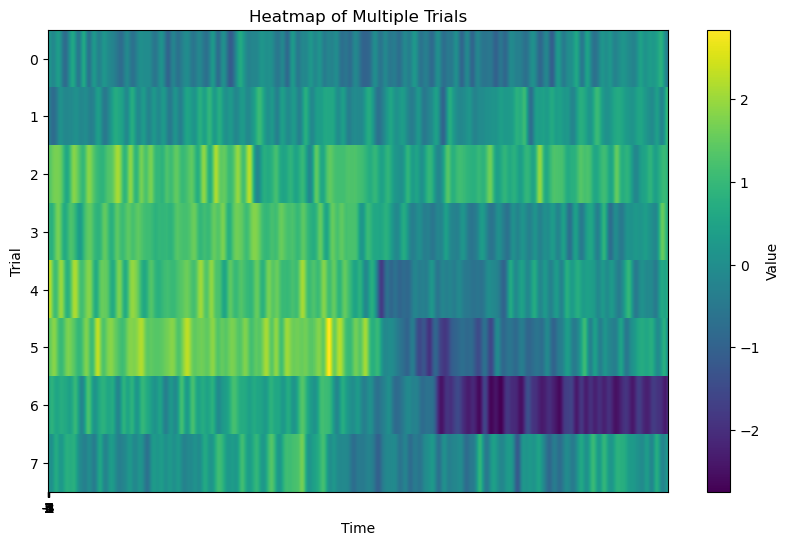

Text(0.5, 1.0, 'Heatmap of Multiple Trials')

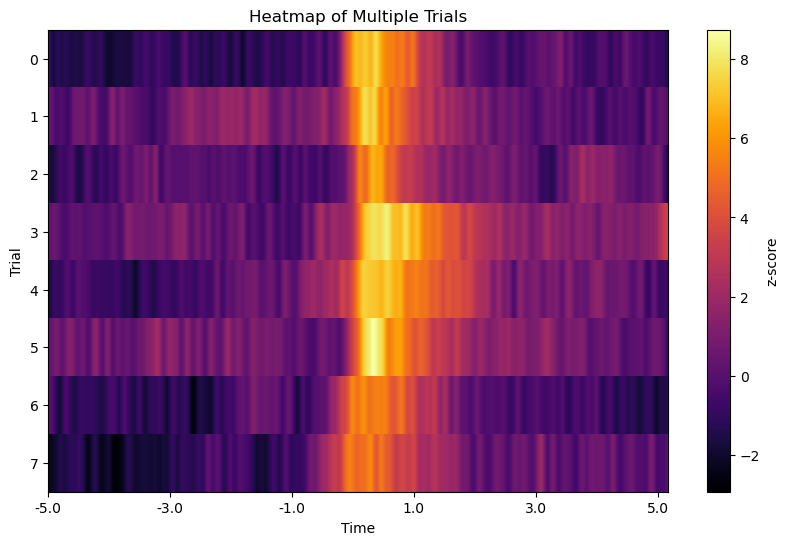

In [36]:
# Heatmap GCaMP
plt.figure(figsize=(10, 6))
plt.imshow(windows_gcamp, aspect="auto", cmap="viridis", interpolation="nearest")
# cbar = fig.colorbar(cs, pad=0.01, fraction=0.02)
plt.colorbar(label="Value")
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("Heatmap of Multiple Trials")

# Define and set x-ticks and labels
plt.xticks(
    ticks=np.linspace(-5, 5, 11),  # Create 11 ticks from -5 to 5
    labels=np.linspace(-5, 5, 11).astype(int),  # Labels for ticks
)
plt.show()


# Heatmap PinkyCaMP
plt.figure(figsize=(10, 6))
plt.imshow(windows_pinky, aspect="auto", cmap="inferno", interpolation="nearest")
# cbar = fig.colorbar(cs, pad=0.01, fraction=0.02)
plt.colorbar(label="z-score")
# Define and set x-ticks and labels
# Here we map data range to label range -5 to 5
x_ticks = np.linspace(0, 10000, num=6)  # Create ticks from 0 to 10000
x_labels = np.linspace(-5, 5, num=6)  # Corresponding labels

plt.xticks(ticks=x_ticks, labels=x_labels)  # Set tick positions  # Set tick labels
plt.xlabel("Time")
plt.ylabel("Trial")
plt.title("Heatmap of Multiple Trials")

Export of z-score data as csv.

In [ ]:
import pandas as pd
import numpy as np
import os

# Konvertiere Listen in NumPy-Arrays
windows_gcamp_array = np.array(windows_gcamp)
windows_pinky_array = np.array(windows_pinky)

# Erstelle DataFrames für jede Datenquelle
df_gcamp = pd.DataFrame(
    windows_gcamp_array,
    columns=[f"GCaMP_{i}" for i in range(windows_gcamp_array.shape[1])],
)
df_pinky = pd.DataFrame(
    windows_pinky_array,
    columns=[f"Pinky_{i}" for i in range(windows_pinky_array.shape[1])],
)

# Überprüfen, ob das Verzeichnis existiert und ggf. erstellen
directory = os.path.dirname(BLOCKPATH)
if not os.path.exists(directory):
    os.makedirs(directory)

# Dateinamen für jede CSV-Datei
gcamp_path = BLOCKPATH + "_GCaMP_data.csv"
pinky_path = BLOCKPATH + "_Pinky_data.csv"
time_path = BLOCKPATH + "_time_data.csv"

# GCaMP Data speichern
df_gcamp.to_csv(gcamp_path, index=False)
print(f"GCaMP Daten wurden erfolgreich in '{gcamp_path}' gespeichert.")

# Pinky Data speichern
df_pinky.to_csv(pinky_path, index=False)
# print(f"Pinky Daten wurden erfolgreich in '{pinky_path}' gespeichert.")